# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
%load_ext lab_black

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# First lets load the data into the notebook

# Define transforms
## YOUR CODE HERE ##
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# Create training set and define training dataloader
## YOUR CODE HERE ##

# Here I decided to split the training data into a validation and a train set.

train_valid_dataset = torchvision.datasets.CIFAR10(
    root="./data/", download=True, train=True, transform=train_transforms
)

train_split = int(0.9 * len(train_valid_dataset))
valid_split = len(train_valid_dataset) - train_split

train_dataset, valid_dataset = torch.utils.data.random_split(
    train_valid_dataset, [train_split, valid_split]
)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
# Create test set and define test dataloader
## YOUR CODE HERE ##
test_dataset = torchvision.datasets.CIFAR10(
    root="./data/", download=True, train=False, transform=test_transforms
)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
# The 10 classes in the dataset

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for b in range(5):

        image = images[b].numpy()
        # Undid the normalisation to view the images

        std = (0.5, 0.5, 0.5)
        mean = (0.5, 0.5, 0.5)
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        print(f"Label: {classes[labels[b]]}")

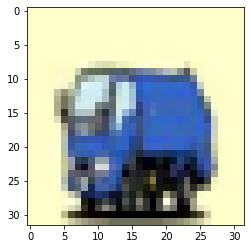

Label: truck


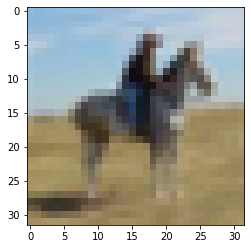

Label: horse


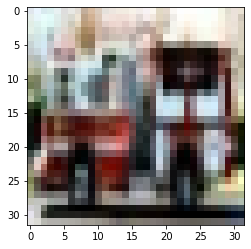

Label: truck


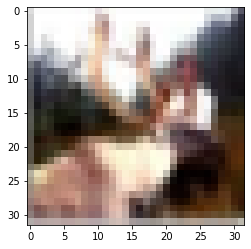

Label: deer


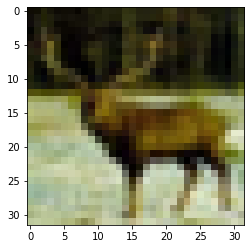

Label: deer


In [5]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
## YOUR CODE HERE ##

# I used a CNN for the first half of the network to extract features of the images then attached some fully connected linear layers on the end of the network.
# The archtecture is adapted from https://jovian.ai/coolasit16/my-cifer10-cnn-on-gpu


class cnn_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, xb):
        xb = self.network(xb)
        xb = F.log_softmax(xb, dim=1)
        return xb

In [7]:
next(iter(trainloader))[0].shape

torch.Size([32, 3, 32, 32])

In [8]:
classifier = cnn_classifier()

# Quick check to make sure our probabilities outputted by the network sum to 1

torch.exp(classifier(next(iter(trainloader))[0])[0, :]).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss()
optimiser = optim.Adam(classifier.parameters(), lr=0.002)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
## YOUR CODE HERE ##

# This cell takes around 30 mins to run on a CPU

device = "cuda" if torch.cuda.is_available() else "cpu"

classifier.to(device)
epochs = 10
train_losses, validation_losses, accuracies = [], [], []
print_steps = 30
for epoch in range(epochs):
    running_train_loss = 0
    for ii, (images, labels) in tqdm(enumerate(trainloader)):
        classifier.train()
        optimiser.zero_grad()

        images, labels = images.to(device), labels.to(device)

        log_ps = classifier(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimiser.step()

        running_train_loss += loss.item()

    with torch.no_grad():
        running_valid_loss = 0
        running_valid_accuracy = 0
        classifier.eval()
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            log_ps = classifier(images)
            loss = criterion(log_ps, labels)
            running_valid_loss += loss.item()

            ps = torch.exp(log_ps)

            _, predicted_class = torch.topk(ps, 1, dim=1)

            accuracy_array = (predicted_class == labels.view(-1, 1)).type(
                torch.FloatTensor
            )
            running_valid_accuracy += accuracy_array.mean()
    train_losses.append(running_train_loss / len(trainloader))
    validation_losses.append(running_valid_loss / len(validloader))
    accuracies.append(running_valid_accuracy / len(validloader))
    print(
        f"Training Loss: {train_losses[-1]}    "
        f"Validation Loss: {validation_losses[-1]}    "
        f"Accuracy: {accuracies[-1]}    "
        f"epoch: {epoch + 1}/{epochs}    "
    )
    torch.save(
        classifier.state_dict(), f"./models/trained_weights_{epoch + 1}_epochs.pth"
    )

1407it [03:14,  7.23it/s]


Training Loss: 1.4778349235622106    Validation Loss: 1.152136820896416    Accuracy: 0.59375    epoch: 1/10    


1407it [03:14,  7.23it/s]


Training Loss: 1.0586386050581509    Validation Loss: 0.9791893976129544    Accuracy: 0.6530652642250061    epoch: 2/10    


1407it [03:14,  7.22it/s]


Training Loss: 0.9023963667097545    Validation Loss: 0.9098588849898357    Accuracy: 0.6841162443161011    epoch: 3/10    


1407it [03:14,  7.23it/s]


Training Loss: 0.8023785893257916    Validation Loss: 0.8620892694801282    Accuracy: 0.7032245397567749    epoch: 4/10    


1407it [03:08,  7.47it/s]


Training Loss: 0.7387599334194885    Validation Loss: 0.8010028813295303    Accuracy: 0.7267118096351624    epoch: 5/10    


1407it [03:03,  7.68it/s]


Training Loss: 0.6732133276914144    Validation Loss: 0.7749223900828391    Accuracy: 0.731488823890686    epoch: 6/10    


1407it [03:13,  7.27it/s]


Training Loss: 0.6360158698412232    Validation Loss: 0.9120835891574811    Accuracy: 0.7155652642250061    epoch: 7/10    


1407it [03:12,  7.29it/s]


Training Loss: 0.5901783656675763    Validation Loss: 0.8086867919013758    Accuracy: 0.7392516136169434    epoch: 8/10    


1407it [03:13,  7.26it/s]


Training Loss: 0.5451902811334077    Validation Loss: 0.7923368824895021    Accuracy: 0.743630588054657    epoch: 9/10    


1407it [03:14,  7.24it/s]


Training Loss: 0.5050960843740581    Validation Loss: 0.8971011598778379    Accuracy: 0.7402468323707581    epoch: 10/10    


Plot the training loss (and validation loss/accuracy, if recorded).

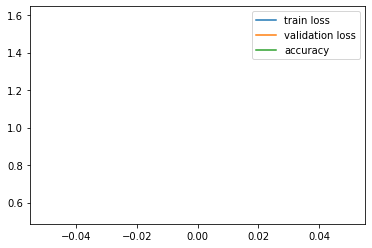

In [12]:
## YOUR CODE HERE ##
plt.plot(train_losses, label="train loss")
plt.plot(validation_losses, label="validation loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()

It can be seen in the figure above that the validation loss slightly increased. Therefore, we will use the model parameters from epoch 8

In [14]:
classifier = cnn_classifier()
state_dict = torch.load("./models/trained_weights_1_epochs.pth")
classifier.load_state_dict(state_dict)

<All keys matched successfully>

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
## YOUR CODE HERE ##
running_accuracy = 0
for images, labels in tqdm(testloader):
    images, labels = images.to(device), labels.to(device)
    log_ps = classifier(images)
    ps = torch.exp(log_ps)
    _, predicted_class = torch.topk(ps, 1, dim=1)

    accuracy_array = (predicted_class == labels.view(-1, 1)).type(torch.FloatTensor)

    running_accuracy += accuracy_array.mean()
print(f"Accuracy on test data: {running_accuracy / len(testloader)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 34.62it/s]

Accuracy on test data: 0.5373402833938599


In [16]:
# This show5 function has added functionality in that it shows the networks predictions for particular images


def show5_predictions(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for b in range(5):

        image = images[b].numpy()
        std = (0.5, 0.5, 0.5)
        mean = (0.5, 0.5, 0.5)
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        image = torch.Tensor(image)
        image = image.view(1, 3, 32, 32)
        log_probs = classifier(image)
        probs = torch.exp(log_probs)
        probabs, predicted_class = torch.topk(log_probs, 1, dim=1)
        # _, preds = torch.max(log_probs, dim=1)
        print(
            f"Label: {classes[labels[b]]}    "
            f"My Classifier: {classes[predicted_class]}    "
        )

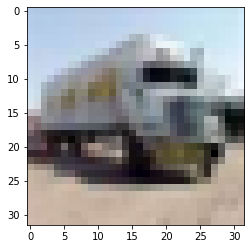

Label: truck    My Classifier: ship    


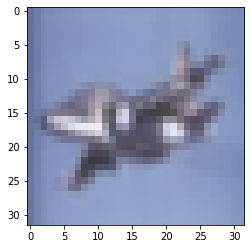

Label: plane    My Classifier: plane    


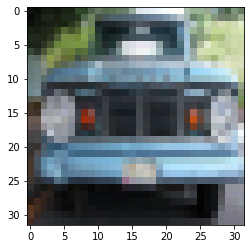

Label: car    My Classifier: ship    


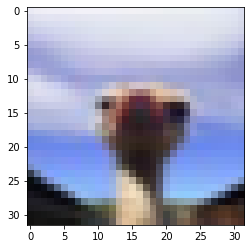

Label: bird    My Classifier: bird    


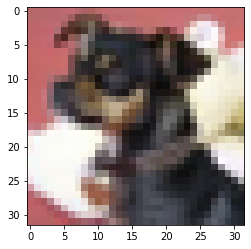

Label: dog    My Classifier: cat    


In [17]:
show5_predictions(testloader)

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
## YOUR CODE HERE ##
torch.save(classifier.state_dict(), "./models/final_model.pth")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would recommend building this model in house since it is more accurate than the model offered on the market. Accuracy scores of 70% have been acheived with a training time of ~30 mins. Other improvements could potentially be made to the selected model such as more layers and dropout to help it generalise better. 
